# Домашнее задание № 7

### Выполнил Кузнецов С.И.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## Задаем целевую переменную в виде числа

In [4]:
le = LabelEncoder()
le.fit(data.income)

fmt = '{:>}\t{:<}'
print(fmt.format('income', 'target'))
for t in ['<=50K', '>50K']:
    print(fmt.format(t, le.transform([t])[0]))

data['target'] = le.transform(data.income)
data.drop(['income'], axis = 1, inplace=True)
data.head()

income	target
<=50K	0
>50K	1


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


## Разобьем выборку на тренировочную и тестовую

In [5]:
test_ind = set(np.random.choice(data.index, size = round(data.shape[0] * .2), replace = False))
data_train = data.loc[set(data.index) - test_ind]
data_test = data.loc[test_ind]
print(' Train dataset size: {}\n Test dataset size:   {}'.format(data_train.shape[0], data_test.shape[0]))

 Train dataset size: 39074
 Test dataset size:   9768


## Выполняем предобработку данных

### Преобразуем качественные фичи в числовые

In [6]:
data_train_prep = pd.get_dummies(data_train)
data_train_prep.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,target,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,103497,10,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Выберем самые сильные фичи

Для этого воспользуемся атрибутом feature_importances_ класса sklearn.tree.DecisionTreeClassifier

In [7]:
dtc = DecisionTreeClassifier()
X = data_train_prep.drop(['target'], axis = 1)
y = data_train.target
dtc.fit(X, y)
fe = pd.Series(dtc.feature_importances_, index=X.columns)
best_features = fe[fe > 0.001].sort_values(ascending=False)

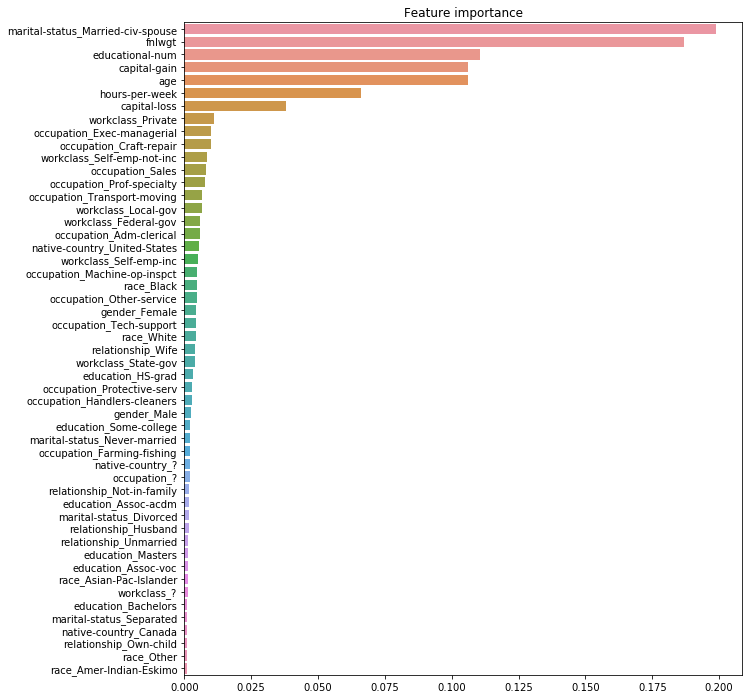

In [8]:
plt.figure(figsize=(10, 12))
sns.barplot(best_features.values, best_features.index)
plt.title('Feature importance')
plt.show()

In [9]:
best_features.index

Index(['marital-status_Married-civ-spouse', 'fnlwgt', 'educational-num',
       'capital-gain', 'age', 'hours-per-week', 'capital-loss',
       'workclass_Private', 'occupation_Exec-managerial',
       'occupation_Craft-repair', 'workclass_Self-emp-not-inc',
       'occupation_Sales', 'occupation_Prof-specialty',
       'occupation_Transport-moving', 'workclass_Local-gov',
       'workclass_Federal-gov', 'occupation_Adm-clerical',
       'native-country_United-States', 'workclass_Self-emp-inc',
       'occupation_Machine-op-inspct', 'race_Black',
       'occupation_Other-service', 'gender_Female', 'occupation_Tech-support',
       'race_White', 'relationship_Wife', 'workclass_State-gov',
       'education_HS-grad', 'occupation_Protective-serv',
       'occupation_Handlers-cleaners', 'gender_Male', 'education_Some-college',
       'marital-status_Never-married', 'occupation_Farming-fishing',
       'native-country_?', 'occupation_?', 'relationship_Not-in-family',
       'education_Assoc

In [10]:
def data_preprocessing(dataset):
    '''
    Осуществляет предобработку массива данных. Возвращает предобработанный (не нормированный) массив данных
    и целевую переменную
    '''
    # Лучшие фичи
    
    best_features = ['marital-status_Married-civ-spouse', 'fnlwgt', 'educational-num', 'age',
       'capital-gain', 'hours-per-week', 'capital-loss', 'workclass_Private',
       'workclass_Self-emp-not-inc', 'occupation_Exec-managerial',
       'occupation_Prof-specialty', 'occupation_Sales', 'race_White',
       'occupation_Craft-repair', 'occupation_Adm-clerical',
       'occupation_Transport-moving', 'workclass_Local-gov',
       'native-country_United-States', 'occupation_Machine-op-inspct',
       'gender_Male', 'workclass_Self-emp-inc', 'workclass_Federal-gov',
       'occupation_Tech-support', 'workclass_State-gov',
       'occupation_Other-service', 'race_Black', 'occupation_Protective-serv',
       'relationship_Wife', 'occupation_Farming-fishing',
       'education_Some-college', 'occupation_Handlers-cleaners',
       'marital-status_Never-married', 'gender_Female', 'education_Assoc-voc',
       'education_Bachelors', 'native-country_?', 'education_Masters',
       'relationship_Not-in-family', 'education_Assoc-acdm',
       'relationship_Husband', 'marital-status_Divorced',
       'race_Asian-Pac-Islander', 'relationship_Own-child',
       'native-country_Philippines', 'occupation_?', 'education_HS-grad',
       'relationship_Other-relative', 'native-country_England']
    
    res = pd.get_dummies(dataset)
    X_res = res[best_features]
    y_res = res.target
    
    return X_res, y_res

In [11]:
X_train, y_train = data_preprocessing(data_train)
X_train.head()

,marital-status_Married-civ-spouse,fnlwgt,educational-num,age,capital-gain,hours-per-week,capital-loss,workclass_Private,workclass_Self-emp-not-inc,occupation_Exec-managerial,...,education_Assoc-acdm,relationship_Husband,marital-status_Divorced,race_Asian-Pac-Islander,relationship_Own-child,native-country_Philippines,occupation_?,education_HS-grad,relationship_Other-relative,native-country_England
1,1,89814,9,38,0,50,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1,336951,12,28,0,40,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1,160323,10,44,7688,40,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,103497,10,18,0,30,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
5,0,198693,6,34,0,30,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_test, y_test = data_preprocessing(data_test)
X_test.head()

,marital-status_Married-civ-spouse,fnlwgt,educational-num,age,capital-gain,hours-per-week,capital-loss,workclass_Private,workclass_Self-emp-not-inc,occupation_Exec-managerial,...,education_Assoc-acdm,relationship_Husband,marital-status_Divorced,race_Asian-Pac-Islander,relationship_Own-child,native-country_Philippines,occupation_?,education_HS-grad,relationship_Other-relative,native-country_England
32768,1,205145,9,27,0,40,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
0,0,226802,7,25,0,40,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
11,1,212465,13,36,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
32781,1,178983,16,52,0,40,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
32782,0,391744,9,40,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Выполним стандартизацию

In [13]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/sergmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Построим логистическую регрессию

In [14]:
lr = LogisticRegression()
params = {'penalty':['l1', 'l2'],
         'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

gs_lr = GridSearchCV(lr, params, scoring='roc_auc', cv = 5)

In [15]:
gs_lr.fit(X_train, y_train)

/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [16]:
lr_final = gs_lr.best_estimator_
lr_final.fit(X_train, y)

/home/sergmath/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
roc_auc_score(y_test, lr_final.predict_proba(X_test)[:,1])

0.908618377228249

## Построим дерево решений

In [18]:
dt = DecisionTreeClassifier()
params = {'max_depth' : list(np.arange(2, 11)),
         'min_samples_split': [2, 5, 10, 50, 100],
         'min_weight_fraction_leaf': [0., 0.01, 0.05, 0.1, 0.5]}

gs_dt = GridSearchCV(dt, params, scoring='roc_auc', cv = 5)

In [19]:
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5, 10, 50, 100], 'min_weight_fraction_leaf': [0.0, 0.01, 0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [20]:
dt_final = gs_dt.best_estimator_
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [21]:
roc_auc_score(y_test, dt_final.predict_proba(X_test)[:,1])

0.907797791581635

### Построим Random Forest модель

In [22]:
rf = RandomForestClassifier()
params = {'n_estimators': [10, 50, 100],
          'max_depth': list(np.arange(5, 15)),
          'min_samples_split': [50, 100, 200]}

gs_rf = GridSearchCV(rf, params, scoring='roc_auc', cv = 5)

In [23]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_split': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [24]:
rf_final = gs_rf.best_estimator_
rf_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
roc_auc_score(y_test, rf_final.predict_proba(X_test)[:,1])

0.9190948842773377

## Сравним результаты

In [27]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_final.predict_proba(X_test)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_final.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_final.predict_proba(X_test)[:,1])

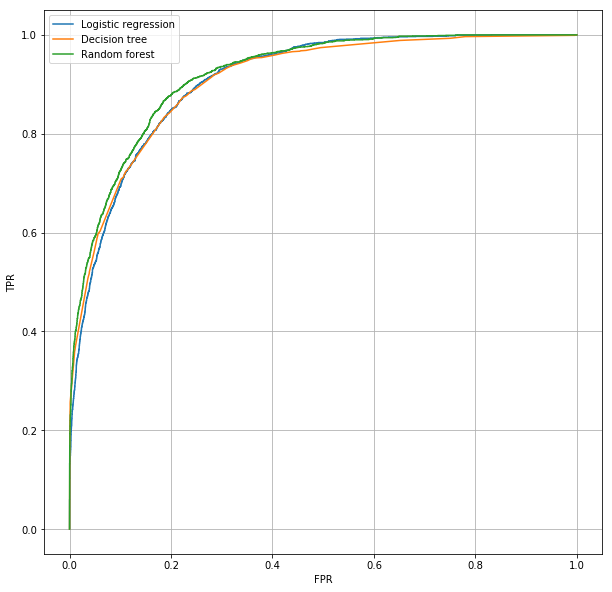

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_dt, tpr_dt)
plt.plot(fpr_rf, tpr_rf)
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['Logistic regression', 'Decision tree', 'Random forest'])
plt.show()